## Feature Selection and Parameters Optimization with Linear Regression Analysis
For this task, I will accomplish the following goal:

1.Experiment with linear regression models to make predictions with numerical data. 

2.Explore more systematic methods for feature selection and for optimizing model parameters for model selection. 



### Data Set Information
The data set is a subset of the "communities and Crime" data set comes from http://facweb.cs.depaul.edu/mobasher/classes/csc478/Data/communities-descr.txt (see detail description in the link) that combines information from the 1990 census data as well as FBI crime data from 1995.  
The target attribute for regression purposes is "ViolentCrimesPerPop". The two identifier attributes "state" and "community name" should be excluded for the regression task.

### 1. Preprocess the Data and Compute Basic Statistics
The provided data is already normalized (see description), so there is no need for additional normalization. 

In [99]:
import numpy as np
import pandas as pd

In [100]:
#load the data
data=pd.read_csv("C:/Users/Rai Chiang/Desktop/478 data/assignment3/communities.csv",na_values=["?"])

#check the data type make sure all of them are in the same formate
data.columns[data.dtypes != "float64"].values

#filter the row that contains null value
data[data.isnull().any(axis=1)]

#drop the row contain null value
data.drop(130,inplace=True)

#split data into x and y:target
data.drop(["state","communityname"],axis=1,inplace=True)
target=np.array(data.ViolentCrimesPerPop,dtype='float64')              
data.drop(["ViolentCrimesPerPop"],axis=1,inplace=True)
data_ready=np.array(data,dtype='float64')

#data exploratory
#print data_ready.describe().T


In [101]:
#preparation 

#Least Squares Generalization y_hat=w.T*x ==> assign 1 to x0 and intercept as w0
X=np.array([np.concatenate((x,[1])) for x in data_ready]) #np.concatenate: join a sequence of arrays along an existing axis.(by default the axis=0)

y_target=target #1D array / When you are passing label (y) data to fit(X,y), it expects y to be 1D list.

### 2. Perform Standard Linear Regression and the Following Tasks
a) Compute the RMSE value on the full training data. 

b) Plot the correlation between the predicted and actual values of the target attribute. 

c) Display the obtained regression coefficients (weights). 

d) Perform 10-fold cross-validation and compare the cross-validation RMSE to the training RMSE 

In [102]:
import pylab as pl

Standard Linear Regession Coefficients:

[[ 1.58394687e-01 -3.02481869e-02  2.12229063e-01 -3.97237986e-02
  -1.27930326e-02  6.36900639e-02  1.22194419e-01 -2.23124229e-01
  -1.42627637e-01  5.64658800e-02 -2.60230134e-01  4.65037847e-02
  -2.00798143e-01 -2.08126761e-01  4.70792802e-02 -1.73534979e-01
   5.82291674e-02  1.05064444e-02 -9.22106451e-02  2.72565616e-01
   9.72713359e-02 -3.26302914e-01 -2.89431388e-02 -3.59461641e-02
   2.28885702e-02  4.31169895e-02  3.76737976e-02  1.19950473e-01
  -1.83693623e-01 -9.47657739e-02  5.55240764e-02  1.07281673e-01
   3.24692051e-03  2.34646790e-01 -3.87649999e-02 -1.03179240e-02
   4.87331629e-01  2.23501778e-01  1.95680279e-01 -6.09603366e-01
  -1.37531328e-01  5.78881584e-02 -3.48705517e-01 -3.63011027e-02
   3.18567061e-04  5.73144283e-02 -1.83223819e-01 -1.56736510e-01
   1.30876568e-01 -1.42989741e-01  2.41003168e-02  3.51231959e-02
  -7.51880947e-02  3.13067150e-02 -3.09769559e-02 -2.23123389e-01
   4.44778318e-01 -1.90505607e-01 -

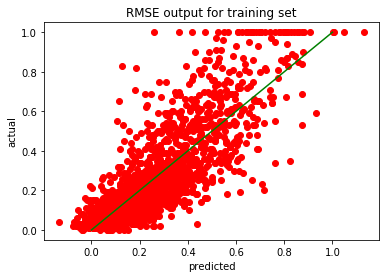

In [104]:
from sklearn.cross_validation import KFold

#RMSE for training set
x=np.mat(X) #Numpy matrices are strictly 2-dimensional, while numpy arrays (ndarrays) are N-dimensional
y=np.mat(y_target)
xTx=(x.T)*x 
if np.linalg.det(xTx)!=0:
    w=(xTx.I)*(x.T*y.T) #be carful with the shape
    y_hat=w.T*x.T #apply the weight w on the test data
    error=y-y_hat
    rmse=np.sqrt((error*error.T)/len(X)) #because dot product only exists in array therefore in matrix use multi;lication
    print "Standard Linear Regession Coefficients:\n\n",W.T,
    print "\n\n RMSE for training set:",rmse

    
#plot the output for training set
pl.plot(y_hat,y,"ro")
pl.plot([0,1.0],[0,1.0],"g-")
pl.xlabel("predicted")
pl.ylabel("actual")
pl.title("RMSE output for training set")


#RMSE from cross validation    
kf=KFold(len(x),n_folds=10)
xval_err=0
for train,test in kf:
    xtx=(x[train].T)*x[train]
    if np.linalg.det(xtx) !=0:
        w=(xtx.I)*(x[train].T*y.T[train])
        y_hat=w.T*x[test].T
        error=y.T[test]-y_hat.T
        xval_err+=np.sqrt((error.T*error)/len(X[test]))
    xval_err=xval_err/10
print "\n\n RMSE for 10 folds Cross Validation:",xval_err


### 3. Feature Selection: apply scikit-learn regression model with a subset of features 

a). Write a script or function for feature selection that takes as input the training data, target variable; the model; and any other parameters that is necessary, and returns the optimal percentage of the most informative features to use. 

b). The approach is done with k-fold cross-validation on the training data (k=5). Then apply feature_selection.SelectPercentile to find the most informative variables. 

c). A list of most informative variables and their weights is shown below
4.Plot the model's mean absolute error values on cross-validation relative to the percentage of selected features


*Note: since this is regression not classification, the scoring function in feature_selection should be ANOVA F value rather than chi2. On the other hand, in order to use cross_validation.cross_val_score with regression, scoring function should be 'mean_absolute_error' as a parameter.

In [107]:
from sklearn import cross_validation,feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import operator

def best_percetile(train_data,train_target):
    lin= LinearRegression()
    results={}
    p=range(1,100,20)
    for i in p:
        fs=feature_selection.SelectPercentile(feature_selection.f_regression,percentile=i)
        fs_train_x=fs.fit_transform(train_data,train_target)
        scores = cross_validation.cross_val_score(lin,fs_train_x,train_target,scoring='neg_mean_squared_error',cv=5)
        results[i]=abs(scores.mean())
    best_p=sorted(results.items(), key=operator.itemgetter(1))[0][0] #sorted the dic by value in increasing order

    
    fs_best=feature_selection.SelectPercentile(feature_selection.f_regression,percentile=(best_p))
    fs_best_train_x=fs_best.fit_transform(train_data,train_target)
    lin.fit(fs_best_train_x,train_target)
    sub_set_feature=fs_best.get_support()
    columns_name_array=data.columns.values
    columns_name_array=np.concatenate((columns_name_array,[1])) #original data has 97 columns, but I set 1 to x0 so the dim became 98
    
    print "The optimal percentage of the most informative features to use:%0.5f"%(best_p),"%"
    print "\nThe most informative variables:\n",columns_name_array[sub_set_feature]
    print "\nWeights for the most informative variables:\n",lin.coef_
    
    
    pl.figure()
    pl.xlabel("percentage of feature selected")
    pl.ylabel("Cross validation mean absolute error")
    sort=sorted(results.items(), key=operator.itemgetter(0))
    x, y = zip(*sort)
    pl.plot(p,y)
       

The optimal percentage of the most informative features to use:41.00000 %

The most informative variables:
['population' 'racepctblack' 'racePctWhite' 'numbUrban' 'medIncome'
 'pctWWage' 'pctWInvInc' 'pctWPubAsst' 'medFamInc' 'perCapInc'
 'NumUnderPov' 'PctPopUnderPov' 'PctLess9thGrade' 'PctNotHSGrad'
 'PctBSorMore' 'PctUnemployed' 'PctEmploy' 'MalePctDivorce' 'FemalePctDiv'
 'TotalPctDiv' 'PctFam2Par' 'PctKids2Par' 'PctYoungKids2Par' 'PctTeen2Par'
 'NumIlleg' 'PctIlleg' 'PctLargHouseFam' 'PctPersOwnOccup'
 'PctPersDenseHous' 'PctHousLess3BR' 'MedNumBR' 'HousVacant'
 'PctHousOccup' 'PctHousOwnOcc' 'PctVacantBoarded' 'PctHousNoPhone'
 'PctWOFullPlumb' 'MedRentPctHousInc' 'NumInShelters' 'NumStreet']

Weights for the most informative variables:
[-0.94619162  0.16624292 -0.01292695  0.73694332  0.07336495 -0.16858478
 -0.19991412  0.06099273  0.04342962 -0.02204247  0.14202864 -0.10154221
 -0.11240481  0.07179141  0.09128007 -0.02418517  0.06504551  0.53866767
  0.35479575 -0.80634224  0.

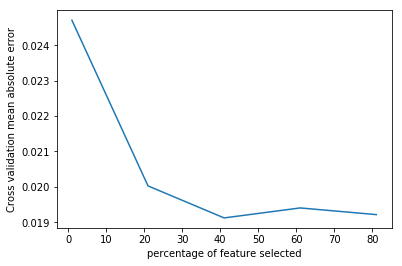

In [108]:
best_percetile(X,y_target)

### 4. Perform both Ridge Regression and Lasso Regression using the modules from sklearn, in each case, perform systematic model selection to identify the optimal alpha parameter. 

a). Create a 20%-80% randomized split of the data. Set aside the test portion; the model selection process should be performed using the 80% training data partition. 

b). Create a function that takes as input the data and target variable; the parameter to vary and a list of its values; the model to be trained; and any other relevant input needed to determine the optimal value for the specified parameter. 

c). The model selection process performs k-fold cross validation (k is a parameter, k=5 for this task).

d).  Plot the error values on the training and cross-validation splits across the specified values of the alpha parameter. 

e). Use the best alpha value and run the model on the set-aside test data.

In [114]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
import pylab as pl
from sklearn.cross_validation import train_test_split

#split data
X_train,X_test,y_train,y_test=train_test_split(X,y_target,test_size=20,random_state=7)

#systematic identify the optimal alpha parameter
def best_model(data,target,values,model,kfolds,result,plot):
    train_rmse=[]
    cv_rmse=[]
    ap=[]
    
    
    for a in values:         
        if model=="Lasso":
            met=Lasso(fit_intercept=True,alpha=a)
            met.fit(data,target)
            p=met.predict(data)
            error=p-target
            total_error=np.dot(error,error)
            rmse_train = np.sqrt(total_error/len(p))
            train_rmse.append(rmse_train)
            ap.append(a)  
            
        elif model=="Ridge":
            met=Ridge(fit_intercept=True,alpha=a)
            met.fit(data,target)
            p=met.predict(data)
            error=p-target
            total_error=np.dot(error,error)
            rmse_train = np.sqrt(total_error/len(p))
            train_rmse.append(rmse_train)
            ap.append(a)
         
        #cross validation
        n_folds=kfolds
        kf=KFold(len(data),n_folds)
        xval_err=0
        for train,test in kf:
            met.fit(data[train],target[train])
            p=met.predict(data[test])
            error=p-target[test]
            xval_err+=np.sqrt(np.dot(error,error)/len(data[test]))
        rmse_kfold=xval_err/n_folds
        cv_rmse.append(rmse_kfold)
   
    
    #find the optimal alpha
    min_rmse=min(cv_rmse)
    for j,i in enumerate(cv_rmse):
        if i == min_rmse:
            optimal_alpha=j 
            
    if result=="show":
        print "rmse on input dataset:",train_rmse
        print "cv_rmse: ",cv_rmse
    else:
        pass
    
    print "optimal_alpha/applied alpha value",ap[optimal_alpha]
    
    #plot the error values on the training and cross-validation 
    if plot=="show":
        pl.plot(ap,train_rmse,label="Train_RMSE")
        pl.plot(ap,cv_rmse,label="Xval_RMSE")
        pl.legend(("Train_RMSE","Xval_RMSE"))
        pl.xlabel("Alpha")
        pl.ylabel("RMSE")
        pl.show()
    else:
        pass
 
    

optimal_alpha/applied alpha value 1.233877551020408


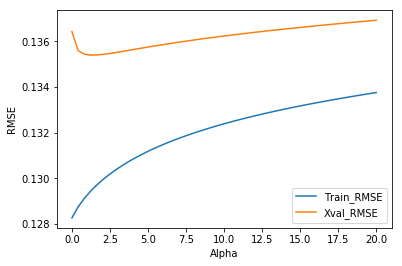

In [116]:
#find the optimal alpha on train set for Ridge Regression

alpha=np.linspace(.01,20,50)    
best_model(X_train,y_train,alpha,model="Ridge",kfolds=5,result="skip",plot="show") 

In [118]:
#Apply the best alpha value on the test data.

print "\nApply Best Alpha on Test Set"
best_model(X_test,y_test,[1.233877551020408],model="Ridge",kfolds=5,result="show",plot="skip") 


Apply Best Alpha on Test Set
rmse on input dataset: [0.07881539547195347]
cv_rmse:  [0.17115965049556398]
optimal_alpha/applied alpha value 1.23387755102


#### According to the results above, the optimal alpha value for ridge regression is 1.23, which is located at the lowest rmse point for cross validation result also on the middle climbing of the train rmse result. When applying this result on the test set the performance yieds very low rmse which proves that the chosen alpha value is the optimal value 
-----------------------------------------------------------------------------------------------------------------------------

optimal_alpha/applied alpha value 0.01


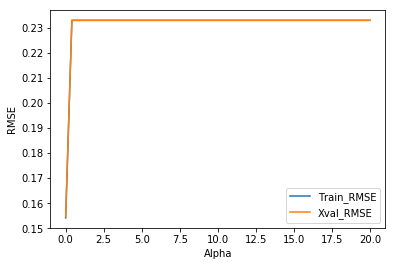

In [112]:
#find the optimal alpha on train set for Lasso Regression

alpha=np.linspace(.01,20,50)    
best_model(X_train,y_train,alpha,model="Lasso",kfolds=5,result="skip",plot="show") 

In [113]:
#Apply the best alpha value on the test data

print "\nApply Best Alpha on Test Set"
best_model(X_test,y_test,[0.01],model="Lasso",kfolds=5,result="show",plot="skip")


Apply Best Alpha on Test Set
rmse on input dataset: [0.1278650431275135]
cv_rmse:  [0.16658058601058096]
optimal_alpha/applied alpha value 0.01


#### According to the plot above, the opimal alpha value for lesso regrssion is 0.01, according to the plot, the rmse from both the train set and the 5 folds cross validation results are highly overlap. The result might indicate that as the alpha value goes up, the rmse will go up dramatically and the model will become serverly overfitting. That's why the optimal alpha value is very small, only when it's small the rmse can be low as shown in the result from the test set application.
--------------------------------------------------------------------------------------------------------------------------------

### 5. Perform regression using Stochastic Gradient Descent

a).Start by a creating randomized 80%-20% train-test split. 

b).SGDRegessor requires that features be standardized (with 0 mean and scaled by standard deviation). Prior to fiting the model, perform the scaling using StandardScaler from sklearn.preprocessing. 

c).For this problem, perform a grid search (using GridSearchCV from sklearn.grid_search) the grid search compare combinations of two penalty parameters ('l2', 'l1') and different values of alpha (alpha could vary from 0.0001 which is the default to relatively large values, say 10). 

d).Using the best parameters, apply the model to the set-aside test data. 

e).Finally, perform model selection (similar to part d, above) to find the best "l1_ratio" parameter using SGDRegressor with  the "elasticnet" penalty parameter. 

f).Using the best mixing ratio, apply the Elastic Net model to the set-aside test data. Provide a summary of your findings from the above experiments.

*Note: "l1_ratio" is The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1;  l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1 penalty; defaults to 0.15. 


In [8]:
from sklearn.cross_validation import train_test_split
#80%-20% train-test split
e_X_train,e_X_test,e_y_train,e_y_test=train_test_split(X,y_target,test_size=20,random_state=8)

#prior to fiting the model, perform the scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
transform_X_train=scaler.fit_transform(e_X_train)

#explor and compare the parameters
from sklearn.linear_model import SGDRegressor
sgdr=SGDRegressor()

#perform a grid search:compare combinations of two penalty parameters ('l2', 'l1') and different values of alpha 0.0001 to 10
from sklearn.grid_search import GridSearchCV

parameters={
    'alpha':np.linspace(0.0001,10,30),
    'penalty': ['l2','L1']
    
           }

gs=GridSearchCV(sgdr,parameters,verbose=1,cv=10)
gs.fit(transform_X_train,e_y_train)
print"The optimal prameters: ",gs.best_params_
print "The grid search score for train set: ",gs.best_score_


C:\Anacon\envs\py27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Anacon\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Fitting 10 folds for each of 60 candidates, totalling 600 fits
The optimal prameters:  {'penalty': 'l2', 'alpha': 0.3449241379310345}
The grid search score:  0.648938205875


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.9s finished


In [17]:
#Using the best parameters, apply the model to the set-aside test data. 

sgdr_best=SGDRegressor(penalty='l2',alpha=0.3449241379310345, n_iter=300)
sgdr_best.fit(transform_X_train,e_y_train)
p=sgdr_best.predict(e_X_test)
error=p-e_y_test
rmse=np.sqrt(np.dot(error,error))/len(p)
print "RMSE for test set with the optimal set of parameters: ", rmse

C:\Anacon\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


RMSE for test set with the optimal set of parameters:  0.07080748665884042


In [16]:
#perform model selection find the best "l1_ratio" parameter using SGDRegressor with the "elasticnet" penalty parameter.

parameters={
    'alpha':np.linspace(0.0001,10,30),
    'penalty': ["elasticnet"],
    'l1_ratio':np.linspace(0,1,50)
           }
sgdr=SGDRegressor()
gs1=GridSearchCV(sgdr,parameters,verbose=1,cv=10)
gs1.fit(transform_X_train,e_y_train)
print"The optimal prameters for SGDRegressor with the 'elasticnet' penalty parameter.:",gs1.best_params_


Fitting 10 folds for each of 1500 candidates, totalling 15000 fits
The optimal prameters for SGDRegressor with the 'elasticnet' penalty parameter.: {'penalty': 'elasticnet', 'alpha': 0.0001, 'l1_ratio': 0.7959183673469387}


[Parallel(n_jobs=1)]: Done 15000 out of 15000 | elapsed:  3.1min finished


In [20]:
#fit the optimal parameters on the test set

sgdr_best1=SGDRegressor(penalty='elasticnet',alpha=0.0001,l1_ratio=0.7959183673469387,n_iter=300)
sgdr_best1.fit(transform_X_train,e_y_train)
p1=sgdr_best1.predict(e_X_test)
error=p1-e_y_test
rmse1=np.sqrt(np.dot(error,error))/len(p)
print "RMSE for test set with the optimal set of parameters: ", rmse1

C:\Anacon\envs\py27\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


RMSE for test set with the optimal set of parameters:  0.07340253296092726
